In [ ]:
%matplotlib inline


# Basic image exploration and fitting

Detect sources, produce a sky image and a spectrum using CTA 1DC data.

## Introduction

**This notebook shows an example how to make a sky image and spectrum
for simulated CTA data with Gammapy.**

The dataset we will use is three observation runs on the Galactic
center. This is a tiny (and thus quick to process and play with and
learn) subset of the simulated CTA dataset that was produced for the
first data challenge in August 2017.


## Setup

As usual, we’ll start with some setup …




In [1]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.makers import (
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    GaussianSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)

## Check setup



In [5]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/gamma/anaconda3/envs/gammapy-1.0/bin/python 
	python_version         : 3.9.15     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.0.1      
	path                   : /home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.23.5     
	scipy                  : 1.9.1      
	astropy                : 5.1.1      
	regions                : 0.6        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.4.0      
	jupyterlab             : 3.4.8      
	matplotlib             : 3.6.2      
	pandas                 : 1.5.0      
	healpy                 : 1.16.1     
	iminuit                : 2.17.0     
	sherpa                 : 4.15.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 2.2.1      


Gammapy en

## Select observations

A Gammapy analysis usually starts by creating a
`~gammapy.data.DataStore` and selecting observations.

This is shown in detail in the other notebook, here we just pick three
observations near the galactic center.




In [6]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

obs_id = [110380, 111140, 111159]
observations = data_store.get_observations(obs_id)

obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME"]
display(data_store.obs_table.select_obs_id(obs_id)[obs_cols])

INFO:gammapy.data.data_store:Observations selected: 3 out of 3.


OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME
,deg,deg,s
int64,float64,float64,float64
110380,359.9999912037958,-1.299995937905366,1764.0
111140,358.4999833830074,1.3000020211954284,1764.0
111159,1.5000056568267741,1.299940468335294,1764.0


In [12]:
print(data_store)

Data store:
HDU index table:
BASE_DIR: /home/gamma/Documents/GitHub/gammapy/gammapy-datasets/1.0/cta-1dc/index/gps
Rows: 24
OBS_ID: 110380 -- 111630
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']


Observation table:
Observatory name: 'N/A'
Number of observations: 4



In [13]:
print(observations)

Observations
Number of observations: 3
Observation

	obs id            : 110380 
 	tstart            : 59235.50
	tstop             : 59235.52
	duration          : 1800.00 s
	pointing (icrs)   : 267.7 deg, -29.6 deg

	deadtime fraction : 2.0%
Observation

	obs id            : 111140 
 	tstart            : 59275.50
	tstop             : 59275.52
	duration          : 1800.00 s
	pointing (icrs)   : 264.2 deg, -29.5 deg

	deadtime fraction : 2.0%
Observation

	obs id            : 111159 
 	tstart            : 59276.50
	tstop             : 59276.52
	duration          : 1800.00 s
	pointing (icrs)   : 266.0 deg, -27.0 deg

	deadtime fraction : 2.0%



## Make sky images

### Define map geometry

Select the target position and define an ON region for the spectral
analysis




In [14]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), npix=(500, 400), binsz=0.02, frame="galactic", axes=[axis]
)
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 400, 9)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 8.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



### Compute images




In [22]:
stacked = MapDataset.create(geom=geom)
stacked.edisp = None
maker = MapDatasetMaker(
    selection=[
        "counts", 
        "background", 
        "exposure", 
        "psf"
    ]
)
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max"], 
    offset_max=2.5 * u.deg
)

for obs in observations:
    cutout = stacked.cutout(
        obs.pointing_radec, 
        width="5 deg"
    )
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)

#
# The maps are cubes, with an energy axis.
# Let's also make some images:
#

dataset_image = stacked.to_image()
geom_image = dataset_image.geoms["geom"]

### Show images

Let’s have a quick look at the images we computed …




<WCSAxesSubplot: title={'center': 'Excess map'}>

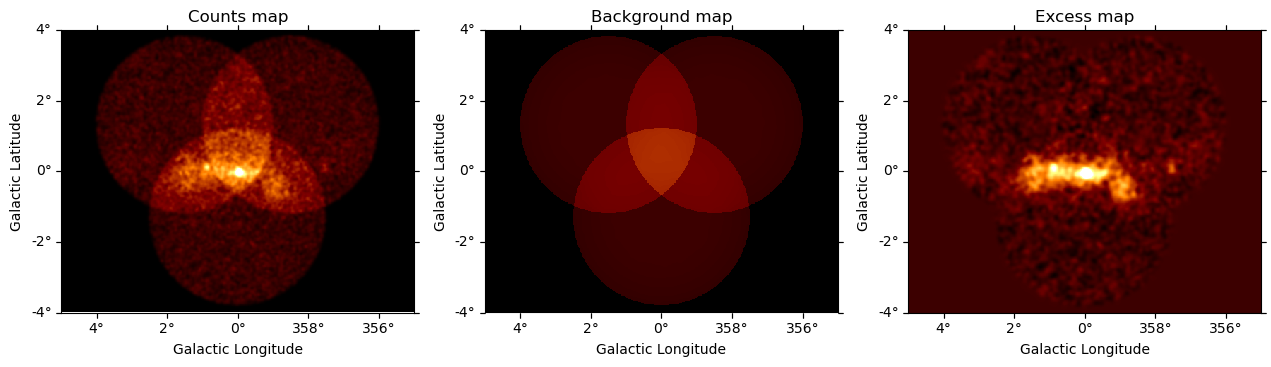

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(15, 5),
    ncols=3,
    subplot_kw={"projection": geom_image.wcs},
    gridspec_kw={"left": 0.1, "right": 0.9},
)

ax1.set_title("Counts map")
dataset_image.counts.smooth(2).plot(ax=ax1, vmax=5)

ax2.set_title("Background map")
dataset_image.background.plot(ax=ax2, vmax=5)

ax3.set_title("Excess map")
dataset_image.excess.smooth(3).plot(ax=ax3, vmax=2)

## Source Detection

Use the class `~gammapy.estimators.TSMapEstimator` and function
`~gammapy.estimators.utils.find_peaks` to detect sources on the images.
We search for 0.1 deg sigma gaussian sources in the dataset.




In [24]:
spatial_model = GaussianSpatialModel(sigma="0.05 deg")
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(
    spatial_model=spatial_model, 
    spectral_model=spectral_model
)

ts_image_estimator = TSMapEstimator(
    model,
    kernel_width="0.5 deg",
    selection_optional=[],
    downsampling_factor=2,
    sum_over_energy_groups=False,
    energy_edges=[0.1, 10] * u.TeV,
)

In [25]:
images_ts = ts_image_estimator.run(stacked)

sources = find_peaks(
    images_ts["sqrt_ts"],
    threshold=5,
    min_distance="0.2 deg",
)
display(sources)

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
35.937,252,197,266.42400,-29.00490
17.899,207,202,266.85900,-28.18386
12.762,186,200,267.14365,-27.84496
9.9757,373,205,264.79470,-30.97749
8.6616,306,185,266.01081,-30.05120
8.0451,298,169,266.42267,-30.08192
7.3817,274,217,265.77047,-29.17056
6.692,90,209,268.07455,-26.10409


To get the position of the sources, simply




In [26]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
print(source_pos)

<SkyCoord (ICRS): (ra, dec) in deg
    [(266.42399798, -29.00490483), (266.85900392, -28.18385658),
     (267.14365055, -27.84495923), (264.79469899, -30.97749371),
     (266.01080642, -30.05120198), (266.4226731 , -30.08192101),
     (265.77046935, -29.1705559 ), (268.07454639, -26.10409446),
     (267.78332719, -25.87897418)]>


Plot sources on top of significance sky image




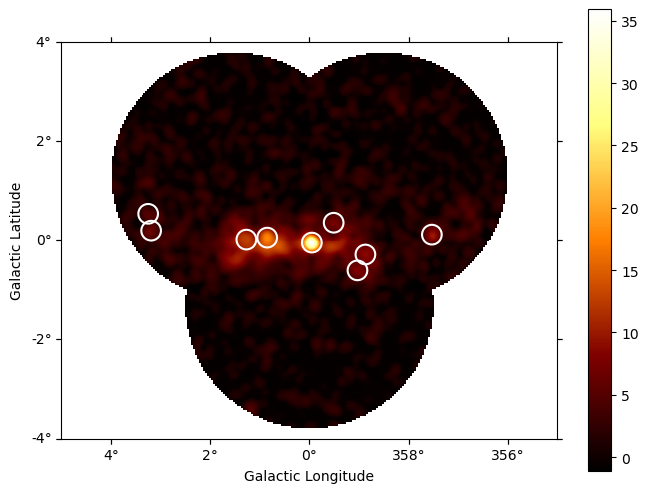

In [27]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": geom_image.wcs})
images_ts["sqrt_ts"].plot(ax=ax, add_cbar=True)

ax.scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=ax.get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
)

## Spatial analysis

See other notebooks for how to run a 3D cube or 2D image based analysis.




## Spectrum

We’ll run a spectral analysis using the classical reflected regions
background estimation method, and using the on-off (often called WSTAT)
likelihood function.




<WCSAxesSubplot: >

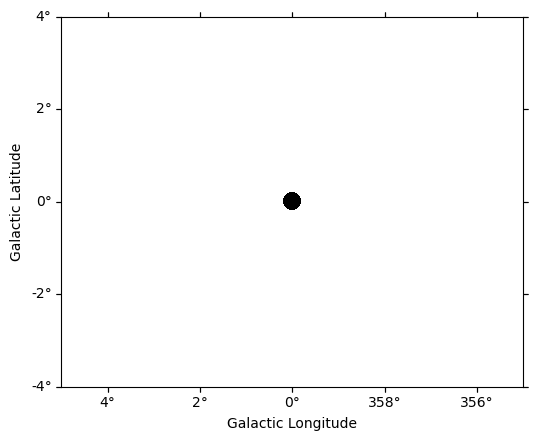

In [28]:
target_position = SkyCoord(0, 0, unit="deg", frame="galactic")
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

exclusion_mask = ~geom.to_image().region_mask([on_region])
plt.figure()
exclusion_mask.plot()

Configure spectral analysis



In [29]:
energy_axis = MapAxis.from_energy_bounds(0.1, 40, 40, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, 200, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

Run data reduction



In [30]:
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=f"obs-{observation.obs_id}"), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

Plot results



<WCSAxesSubplot: >

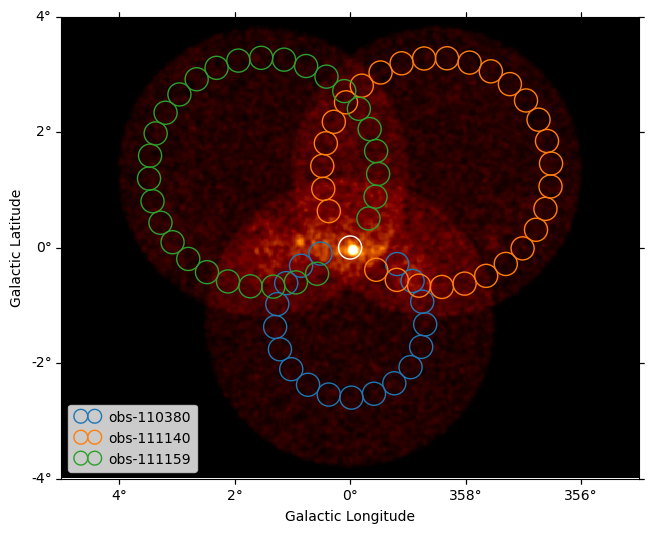

In [31]:
plt.figure(figsize=(8, 6))
ax = dataset_image.counts.smooth("0.03 deg").plot(vmax=8)

on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="white")
plot_spectrum_datasets_off_regions(datasets, ax=ax)

### Model fit

The next step is to fit a spectral model, using all data (i.e. a
“global” fit, using all energies).




In [32]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

model = SkyModel(spectral_model=spectral_model, name="source-gc")

datasets.models = model

fit = Fit()
result = fit.run(datasets=datasets)
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 104
	total stat : 88.36

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



### Spectral points

Finally, let’s compute spectral points. The method used is to first
choose an energy binning, and then to do a 1-dim likelihood fit /
profile to compute the flux and flux error.




In [33]:
# Flux points are computed on stacked observation
stacked_dataset = datasets.stack_reduce(name="stacked")

print(stacked_dataset)

energy_edges = MapAxis.from_energy_bounds("1 TeV", "30 TeV", nbin=5).edges

stacked_dataset.models = model

fpe = FluxPointsEstimator(energy_edges=energy_edges, source="source-gc")
flux_points = fpe.run(datasets=[stacked_dataset])
flux_points.to_table(sed_type="dnde", formatted=True)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 413 
  Total background counts         : 85.43
  Total excess counts             : 327.57

  Predicted counts                : 98.34
  Predicted background counts     : 98.34
  Predicted excess counts         : nan

  Exposure min                    : 9.94e+07 m2 s
  Exposure max                    : 2.46e+10 m2 s

  Number of total bins            : 40 
  Number of fit bins              : 30 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 658.76

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2095 
  Acceptance                      : 40 
  Acceptance off                  : 990 



e_ref,e_min,e_max,dnde,dnde_err,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool
1.375,0.946,2.000,1.447e-12,1.783e-13,152.513,12.350,105.77522448844552,83.89892,13.412,False,106.0,True
2.699,2.000,3.641,3.563e-13,4.835e-14,150.654,12.274,73.02511912240496,63.13247,2.245,False,73.0,True
5.295,3.641,7.700,7.332e-14,1.138e-14,121.570,11.026,53.98359208480558,47.455875,0.624,False,54.0,True
11.198,7.700,16.284,6.353e-15,2.154e-15,21.789,4.668,13.188429838197434,10.660447,5.744,False,13.0,True
21.971,16.284,29.645,1.109e-15,6.938e-16,6.250,2.500,4.145310538825691,3.197989,2.899,False,4.0,True


### Plot

Let’s plot the spectral model and points. You could do it directly, but
for convenience we bundle the model and the flux points in a
`FluxPointDataset`:




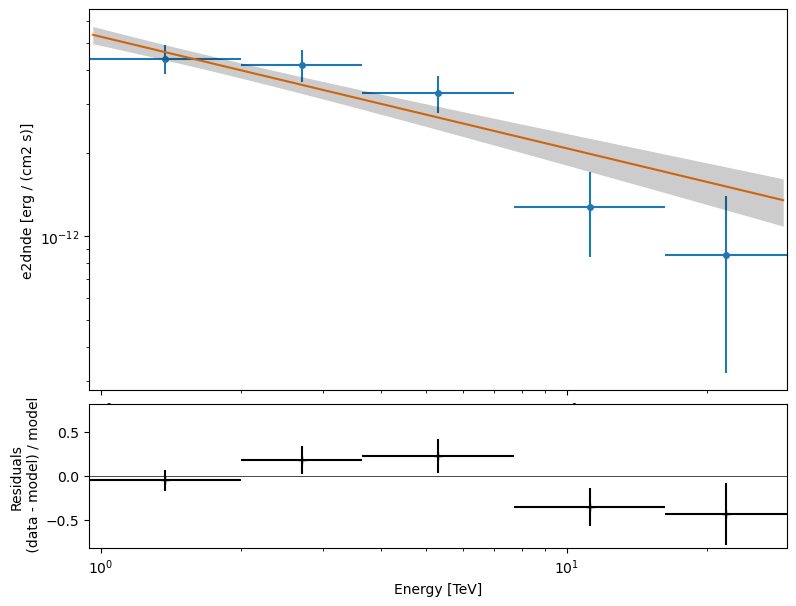

In [34]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model)
flux_points_dataset.plot_fit()
plt.show()

## Exercises

-  Re-run the analysis above, varying some analysis parameters, e.g.

   -  Select a few other observations
   -  Change the energy band for the map
   -  Change the spectral model for the fit
   -  Change the energy binning for the spectral points

-  Change the target. Make a sky image and spectrum for your favourite
   source.

   -  If you don’t know any, the Crab nebula is the “hello world!”
      analysis of gamma-ray astronomy.




In [ ]:
# print('hello world')
# SkyCoord.from_name('crab')

## What next?

-  This notebook showed an example of a first CTA analysis with Gammapy,
   using simulated 1DC data.
-  Let us know if you have any question or issues!


